<h2>Linear SVM</h2>

<p>This notebook implements a linear support vector machine.</p>

<h3>Python Initialization</h3>

In [1]:
import sys
import time
import numpy as np
from numpy.matlib import repmat

from scipy.stats import linregress
import scipy.optimize as so

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

print('Running python %s' % sys.version.split(' ')[0])

Running python 3.8.9


<h3>Generate and Visualize Data</h3>

Let's generate some linearly seperable data and visualize it. Run the cell below to generate and visualize the data.

In [2]:
def generate_data(n: int=100):
    # Sample data from Gaussian distribution N(0, 1)
    X_train = np.random.randn(n, 2)
    y_train = np.ones(n, dtype=np.int)
    
    # the first half the data is sampled from N([5,5], 1)
    X_train[:n // 2] += 5
    # the second half the data is sampled from N([10,10], 1)
    X_train[n // 2:] += 10
    y_train[n // 2:] = -1
    
    return X_train, y_train

In [3]:
def visualize_2D(X_train, y_train):
    """
    This function is used to visualize the 2D dataset.
    
    Inputs:
    ------
    X_train : training features
    y_train : training labels
    
    Outputs:
    -------
    None : This function plots a figure
    """
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(y_train)
    
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c, 0], X_train[y_train == c, 1], marker=marker_symbols[idx], label=str(c))
        
    plt.legend(loc=2)
    plt.show()

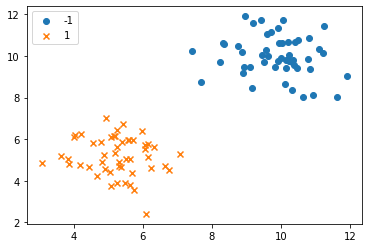

In [4]:
X_train, y_train = generate_data()
visualize_2D(X_train, y_train)

<h2>Linear SVM</h2>

Recall that the unconstrained loss function for linear SVM is 

$$
\begin{aligned}
\min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2} \text{ regularizer}}  +  C\
\sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ]}_{\text{hinge loss}}
\end{aligned}
$$

However, the hinge loss is not differentiable when $1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b)= 0$. So, we are going to use the squared hinge loss instead:

$$
\begin{aligned}
\min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ] ^2}_{\text{squared hinge loss}}
\end{aligned}
$$

<h3>Part One: Loss Function</h3>

This implements the function <code>loss</code>, which takes in training data <code>X_train</code> ($n\times d$) and labels <code>y_train</code> ($n$) with <code>y_train[i]</code>$\in \{-1,1\}$ and evaluates the <b>squared</b> hinge loss of classifier $(\mathbf{w},b)$.

In [5]:
def loss(w, b, X_train, y_train, C):
    """
    Inputs:
    ------
    w       : d dimensional weight vector
    b       : scalar (bias)
    X_train : nxd dimensional matrix (each row is an input vector)
    y_train : n dimensional vector (each entry is a label)
    C       : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    
    Outputs:
    -------
    loss : the total loss obtained with (w, b) on X_train and y_train (scalar)
    """
    margin = y_train * (X_train @ w + b)
    
    return np.dot(w, w) + C * (np.sum(np.maximum(1 - margin, 0) ** 2))

<h3>Part Two: Gradient of Loss Function</h3>

Now, this implements <code>gradient</code>, which takes in the same arguments as the <code>loss</code> function but returns gradient of the loss function with respect to $(\mathbf{w},b)$.

First, we take the derivative of the squared hinge loss with respect to $\mathbf w$:

$$
\frac{\partial \mathcal L}{\partial \mathbf w} = 2 \mathbf w + C
\sum_{i=1}^{n} 2  \max \left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ]  (-y_i \mathbf x_i)
$$

Second, we take the derivative with respect to $b$:

$$
\frac{\partial \mathcal L}{\partial b} = C  \sum_{i=1}^{n} 2  \max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ]  (-y_i)
$$

In [6]:
def gradient(w, b, X_train, y_train, C):
    """
    Inputs:
    ------
    w       : d dimensional weight vector
    b       : scalar (bias)
    X_train : nxd dimensional matrix (each row is an input vector)
    y_train : n dimensional vector (each entry is a label)
    C       : constant (scalar that controls the tradeoff between l2-regularizer and hinge-loss)
    
    Outputs:
    -------
    wgrad : d dimensional vector (the gradient of the hinge loss with respect to the weight, w)
    bgrad : constant (the gradient of the hinge loss with respect to the bias, b)
    """
    margin = y_train * (X_train @ w + b)
    hinge = np.maximum(1 - margin, 0)
    wgrad = 2 * w + C * np.sum((2 * hinge * -y_train).reshape(-1, 1) * X_train, axis=0)
    bgrad = C * np.sum(2 * hinge * -y_train, axis=0)
    
    return wgrad, bgrad

<h3>Obtain the Linear SVM</h3>

By calling the following minimization routine implemented in the cells below, we will obtain your linear SVM.

In [7]:
def minimize(objective, grad, X_train, y_train, C):
    
    def loss_lambda(X):
        return objective(X[:-1], X[-1], X_train, y_train, C)
    
    def grad_lambda(X):
        return np.append(*grad(X[:-1], X[-1], X_train, y_train, C))
    
    n, d = X_train.shape
    w = np.zeros(d)
    b = np.zeros(1)
    
    init = np.append(w, np.array(b))
    sol = so.minimize(loss_lambda, x0=init, jac=grad_lambda, method='SLSQP', options={'ftol': 1e-70, 'maxiter': 1000})
    
    w = sol.x[:-1]
    b = sol.x[-1]
    
    return w, b, sol.fun

In [8]:
w, b, final_loss = minimize(objective=loss, grad=gradient, X_train=X_train, y_train=y_train, C=1000)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss))

The Final Loss of your model is: 0.4788


<h3>Visualize the Decision Boundary</h3>

Now, let's visualize the decision boundary on our linearly separable dataset. Since the dataset is linearly separable, we should obtain $0\%$ training error with sufficiently large values of $C$ (e.g. $C>1000$).

In [9]:
def visualize_classifier(X_train, y_train, w, b):
    """
    This function is used to visualize the decision boundary.
    
    Inputs:
    ------
    X_train : training features
    y_train : training labels
    w       : the classifier weights
    b       : the classifier bias
    
    Outputs:
    -------
    None : a figure is returned to the screen
    """
    y_train = np.array(y_train).flatten()
    w = np.array(w).flatten()
    
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    colors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(y_train)
    
    plt.figure()
    
    res = 300
    xrange = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), res)
    yrange = np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), res)
    pixelX = np.matlib.repmat(xrange, res, 1)
    pixelY = np.matlib.repmat(yrange, res, 1).T
    
    X_test = np.array([pixelX.flatten(), pixelY.flatten()]).T
    testpreds = X_test @ w + b
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=colors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c, 0], X_train[y_train == c, 1], marker=marker_symbols[idx], color='k', label=str(c))
        
    alpha = -1 * b / (w ** 2).sum()
    plt.quiver(w[0] * alpha, w[1] * alpha, w[0], w[1], linewidth=2, color=[0, 1, 0])
    plt.axis('tight')
    plt.legend(loc=2)
    plt.show()

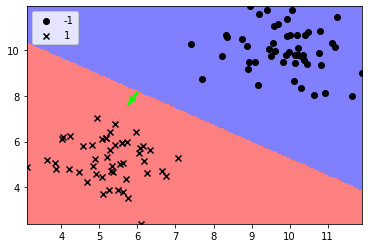

Training error: 0.00 %


In [10]:
visualize_classifier(X_train, y_train, w, b)

# Calculate the training error
predictions = np.sign(X_train.dot(w) + b)
error = np.mean(predictions != y_train)
print('Training error: {:.2f} %'.format(100 * error))